## Inference using ARIMA errors using Kalman filter

In [1]:
import pints
import pints.toy as toy
import pints.plot
import numpy as np
import matplotlib.pyplot as plt

## Generate model with ARMA errors

As before, we assume that the observed data $y(t)$ follows

$$y(t)= f(t; \theta) + \epsilon(t).$$

Under the ARMA(1,1) noise model, the error terms $\epsilon(t)$ have 1 moving average term and 1 autoregressive term. Therefore, 

$$\epsilon(t) = \rho \epsilon(t-1) + \nu(t) + \phi \nu(t-1),$$

where the white noise term $\nu(t) \overset{i.i.d.}{\sim} \mathcal{N}(0, \sigma \sqrt{(1 - \rho^2) / (1 + 2 \rho \phi + \phi^2))}$. The noise process standard deviation is such that the marginal distribution of $\epsilon$ is,

$$\epsilon\sim\mathcal{N}(0, \sigma).$$

The ARMA(1,1) noise model is available in Pints using `pints.ARMA11LogLikelihood`. As before, the code below shows how to generate a time series with ARMA(1,1) noise and perform Bayesian inference with the correct likelihood and with an incorrect IID assumption.

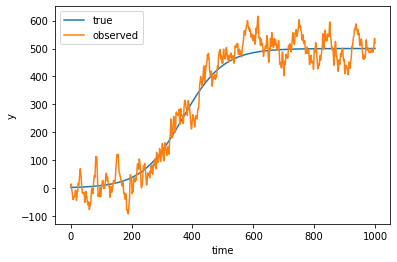

In [2]:
# Load a forward model
model = toy.LogisticModel()

# Create some toy data
real_parameters = [0.015, 500]
times = np.linspace(0, 1000, 1000)
org_values = model.simulate(real_parameters, times)

# Add noise
noise = 40
rho = 0.9
phi = 0.95
errors = pints.noise.arma11(rho, phi, noise, len(org_values))
values = org_values + errors

# Show the noisy data
plt.figure()
plt.plot(times, org_values)
plt.plot(times, values)
plt.xlabel('time')
plt.ylabel('y')
plt.legend(['true', 'observed'])
plt.show()

## Fit model using Statsmodels' ARIMA Kalman filter

Here, we fit an ARMA(1,1) model.

Running...
Done!


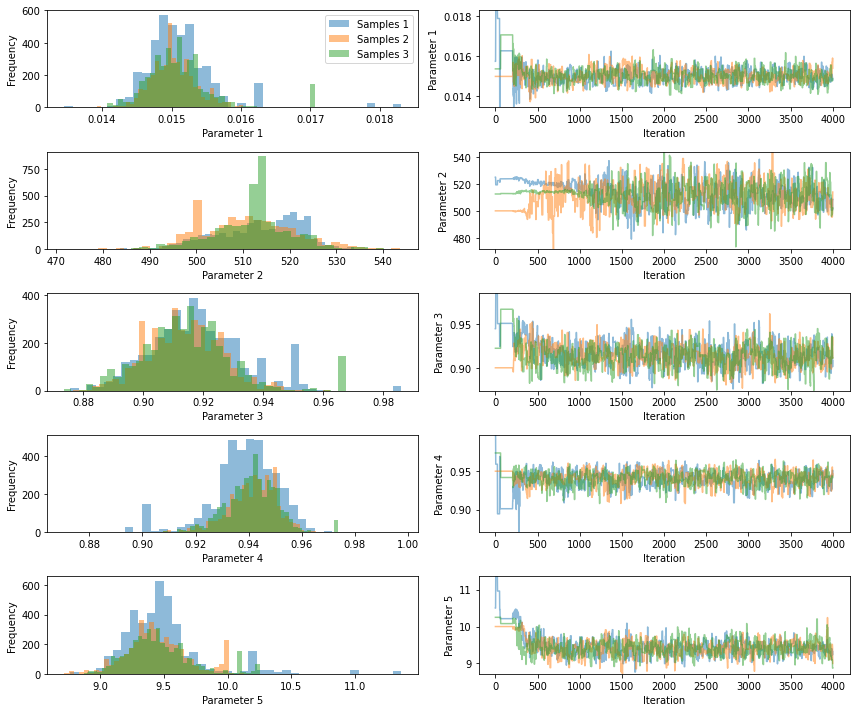

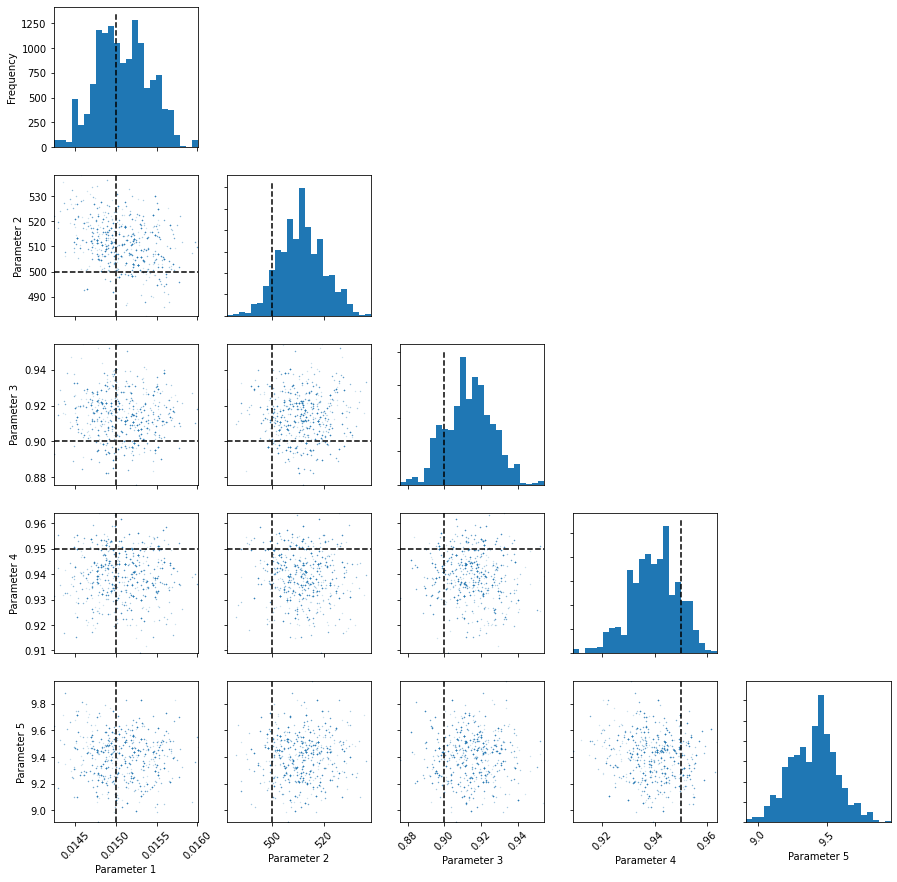

In [3]:
from statsmodels.tsa.arima.model import ARIMA

model = toy.LogisticModel()

class ARIMALogLikelihood(pints.ProblemLogLikelihood):
    def __init__(self, problem, arima_order):
        super(ARIMALogLikelihood, self).__init__(problem)
        self._nt = len(self._times) - 1
        self._no = problem.n_outputs()
        
        if len(arima_order) != 3:
            raise ValueError("ARIMA (p, d, q) orders must be tuple of length 3.")
        self._arima_order = arima_order
        p = arima_order[0]
        d = arima_order[1]
        q = arima_order[2]
        self._p = p
        self._q = q
        self._d = d
        
        self._n_parameters = problem.n_parameters() + (p + q + 1) * self._no
    
    def __call__(self, x):
        x = x.tolist()
        m = (self._p + self._q + 1) * self._no
        parameters = x[-m:]
        sol = self._problem.evaluate(x[:-m])
        model = ARIMA(endog=self._values,
                      order=self._arima_order,
                      exog=sol)
        # first param is trend (if model not differenced),
        # second is coefficient on ODE soln
        # see model.param_names
        sigma2 = parameters[-1]**2
        parameters = parameters[:-1] + [sigma2]
        if self._d == 0:
            full_params = [0, 1] + parameters
        else:
            full_params = [1] + parameters 
        return model.loglike(full_params)
    
# Create an object with links to the model and time series
problem = pints.SingleOutputProblem(model, times, values)

# Create a log-likelihood function (adds an extra parameter!)
log_likelihood = ARIMALogLikelihood(problem, arima_order=(1, 0, 1))

# Create a uniform prior over both the parameters and the new noise variable
log_prior = pints.UniformLogPrior(
    [0.01, 400, 0, 0, noise * 0.1],
    [0.02, 600, 1, 1, noise * 100],
)

# Create a posterior log-likelihood (log(likelihood * prior))
log_posterior = pints.LogPosterior(log_likelihood, log_prior)

# Choose starting points for 3 mcmc chains
real_parameters = np.array(real_parameters + [rho, phi, 10])
xs = [
    real_parameters * 1.05,
    real_parameters * 1,
    real_parameters * 1.025
]

# Create mcmc routine
mcmc = pints.MCMCController(log_posterior, 3, xs, method=pints.HaarioBardenetACMC)

# Add stopping criterion
mcmc.set_max_iterations(4000)

# Disable logging
mcmc.set_log_to_screen(False)

# Run!
print('Running...')
chains = mcmc.run()
print('Done!')

# Show traces and histograms
pints.plot.trace(chains)

# Discard warm up
chains = chains[:, 2000:, :]

# Look at distribution in chain 0
pints.plot.pairwise(chains[0], kde=False, ref_parameters=real_parameters)

# Show graphs
plt.show()

Look at results. Note that 'sigma' will be different to the value used to generate the data, due to a different definition.

In [9]:
results = pints.MCMCSummary(chains=chains,
                            parameter_names=['r', 'k', 'rho', 'phi', 'sigma'])
print(results)

param    mean    std.    2.5%    25%     50%     75%     97.5%    rhat    ess
-------  ------  ------  ------  ------  ------  ------  -------  ------  ------
r        0.02    0.00    0.01    0.01    0.02    0.02    0.02     1.01    380.20
k        512.04  9.27    494.65  505.81  511.84  518.27  530.06   1.01    362.49
rho      0.91    0.01    0.89    0.90    0.91    0.92    0.94     1.00    369.75
phi      0.94    0.01    0.92    0.93    0.94    0.95    0.96     1.00    396.11
sigma    9.42    0.19    9.06    9.30    9.42    9.53    9.80     1.02    339.95


## Look at ARIMA(4, 1, 4) model parameter names

Note that, you can ignore x1. So just pass ar1, ar2, ar3, ar4, ma1, ma2, ma3, ma4

In [4]:
sol = problem.evaluate([0.15, 500])
model = ARIMA(endog=problem.values(),
              order=(4, 1, 4),
              exog=sol)
model.param_names

['x1',
 'ar.L1',
 'ar.L2',
 'ar.L3',
 'ar.L4',
 'ma.L1',
 'ma.L2',
 'ma.L3',
 'ma.L4',
 'sigma2']

# Trying fitting using a state space model

See [here](https://www.statsmodels.org/devel/generated/statsmodels.tsa.statespace.structural.UnobservedComponents.html#statsmodels.tsa.statespace.structural.UnobservedComponents) for a description of these huge family of models.

In [45]:
from statsmodels.tsa.statespace.structural import UnobservedComponents

sol = problem.evaluate([0.15, 500])
model = UnobservedComponents(endog=problem.values(), level='ntrend', exog=sol)
model.param_names

['sigma2.irregular', 'beta.x1']

In [55]:
class StateSpaceLogLikelihood(pints.ProblemLogLikelihood):
    def __init__(self, problem, ss_model, ss_n_params):
        super(StateSpaceLogLikelihood, self).__init__(problem)
        self._nt = len(self._times) - 1
        self._no = problem.n_outputs()
        self._ss_model = ss_model
        self._ss_n_params = ss_n_params
        self._n_parameters = problem.n_parameters() + ss_n_params * self._no
    
    def __call__(self, x):
        x = x.tolist()
        m = self._ss_n_params * self._no
        parameters = x[-m:]
        sol = self._problem.evaluate(x[:-m])
        model = UnobservedComponents(endog=problem.values(),
                                     level=self._ss_model, exog=sol)
        return model.loglike(parameters + [1])

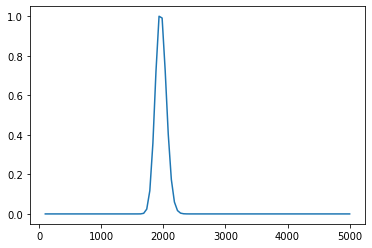

In [75]:
log_likelihood = StateSpaceLogLikelihood(problem, 'ntrend', 1)
x = np.linspace(100, 5000, 100)
lls = [log_likelihood(np.array([0.015, 500, a])) for a in x]
plt.plot(x, np.exp(lls-max(lls)))
plt.show()

Running...
Done!


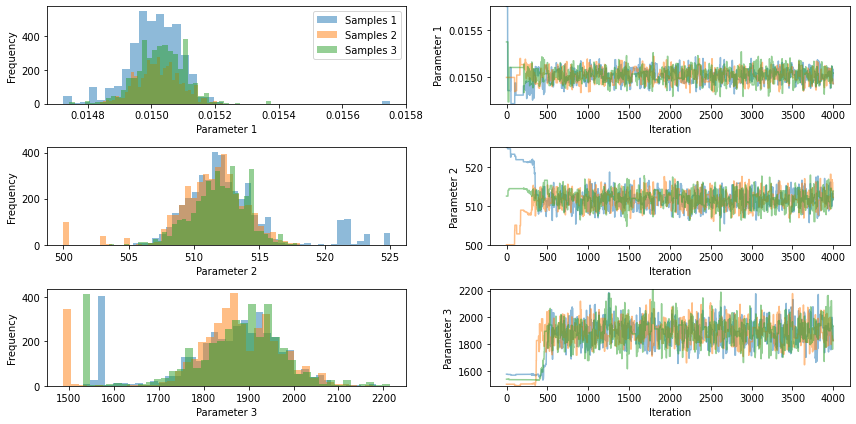

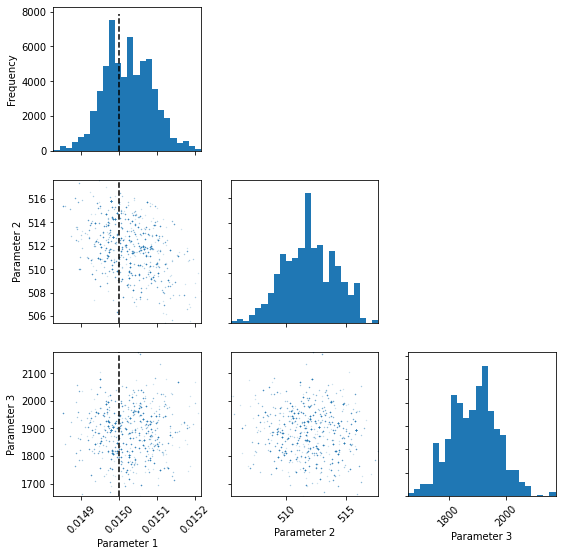

In [77]:
model = toy.LogisticModel()

# Create an object with links to the model and time series
problem = pints.SingleOutputProblem(model, times, values)

# Create a log-likelihood function
log_likelihood = StateSpaceLogLikelihood(problem, 'ntrend', 1)

# Create a uniform prior over both the parameters and the new noise variable
log_prior = pints.UniformLogPrior(
    [0.00, 400, 0],
    [0.05, 600, 3000],
)

# Create a posterior log-likelihood (log(likelihood * prior))
log_posterior = pints.LogPosterior(log_likelihood, log_prior)

# Choose starting points for 3 mcmc chains
real_parameters = np.array([0.015, 500] + [1500])
xs = [
    real_parameters * 1.05,
    real_parameters * 1,
    real_parameters * 1.025
]

# Create mcmc routine
mcmc = pints.MCMCController(log_posterior, 3, xs, method=pints.HaarioBardenetACMC)

# Add stopping criterion
mcmc.set_max_iterations(4000)

# Disable logging
mcmc.set_log_to_screen(False)

# Run!
print('Running...')
chains = mcmc.run()
print('Done!')

# Show traces and histograms
pints.plot.trace(chains)

# Discard warm up
chains = chains[:, 2000:, :]

# Look at distribution in chain 0
pints.plot.pairwise(chains[0], kde=False, ref_parameters=real_parameters)

# Show graphs
plt.show()